In [1]:
from dfply import *
import pandas as pd
import numpy as np
import datetime

In [2]:
@make_symbolic
#convert date strings into pandas datatime object.
def to_datetime_standard(s:str, infer_datetime_format=True):
    return pd.to_datetime(s, infer_datetime_format=infer_datetime_format)

In [3]:
#The assumption I made with the electricity consumptions is I grouped together observations that have the same hours on 
#the same day. For example, the minute consumption at 1:20pm belongs to the 1:00pm group on that date. 
df1 = pd.read_csv('new.app4.csv')
df1 = (df1 >> select(1,2) >> # select the time column and W_min column
 mutate(time = X.time.apply(to_datetime_standard)) >> #convert the date into pandas's datetime format
 mutate(time = X.time.dt.to_period('H')) >> #want consumption in df1 in hours precision
 group_by(X.time) >>  #use group_by to group observations having the same hours and same date together.
 summarize(some_appliance_kwh=X['W_min'].sum()/1000)#summing minute data so that the same group have an amount of W/hour,
                                                    #then the number is converted to kw by dividing 1000.
)

In [4]:
df1.head(10)

,time,some_appliance_kwh
0,2013-06-07 11:00,57.388943
1,2013-06-07 12:00,27.227961
2,2013-06-07 13:00,111.476298
3,2013-06-07 14:00,109.021960
4,2013-06-07 15:00,5.773963
5,2013-06-07 16:00,1.619193
6,2013-06-07 17:00,12.081027
7,2013-06-07 18:00,25.478736
8,2013-06-07 19:00,11.360621
9,2013-06-07 20:00,1.054541


In [5]:
@make_symbolic
#This funciton intends to convert date strings in USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv to pandas datatime.
def to_datetime(s:str): 
    if s[8:10] != '24': #24:00 is not recognized in pandas, this if-else part checks it.
        return pd.to_datetime(s, format=" %m/%d  %H:%M:%S").replace(year=2013)
    change_to_zeros = s[0:8] + '00' + s[10:] #if 24:00 is present, move the date one day ahead and change the clock to 0:00
    return pd.to_datetime(change_to_zeros, format=" %m/%d  %H:%M:%S").replace(year=2013) + datetime.timedelta(days=1)
    #setting the year to 2013 so that some dates can overlap
    

In [6]:
@make_symbolic
#These functions return the day of the week and hour respectively for a timestamp input 
def get_day(time_stamp):
    return time_stamp.weekday()
def get_hour(time_stamp):
    return time_stamp.hour

In [7]:
df2 = pd.read_csv('USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv')
df = (df2 >> rename(time = 'Date/Time') >> #rename the date/time column so that 2 df's have a common column name
 mutate(time = X.time.apply(to_datetime)) >> 
 mutate(time = X.time.dt.to_period('H')) >>  
 inner_join(df1, by = 'time') >> #merge the two dataframes based on overlapping period
 mutate(total_consumption_kwh = X.select_dtypes(include='number').sum(axis=1)) >>#create one more column of total consumption
 mutate(weekday = X.time.dt.to_timestamp().apply(get_day)) >>
 mutate(hour = X.time.dt.to_timestamp().apply(get_hour))
)

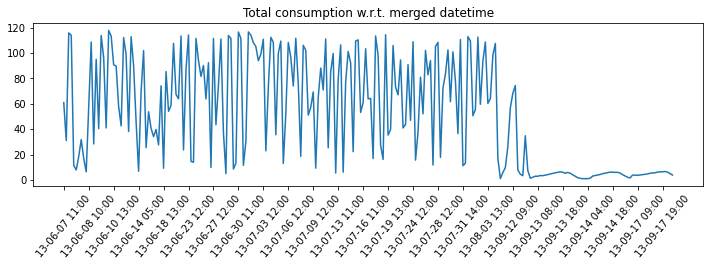

In [8]:
#trying plotting the merged dataframe to observe patterns and abnormality.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

#plot total consumption w.r.t. merged datetime.
#Since the merged datetime generates uniform x-axis, the data will not look smooth enough for non-uniform datetime.
#Therefore, the x-axis will be of type string.
x = df.time.dt.strftime('%y-%m-%d %H:%M')
y = df.iloc[:,15]

fig, ax = plt.subplots()
fig.set_size_inches(12,3)
plt.plot(x, y)
plt.xticks(rotation=50)
ax.set_title('Total consumption w.r.t. merged datetime')
ax.set_xticks([x[i] for i in range(0, len(x), 10)]);

#The total electricity consumption fluctuates between 0 to 120 before around mid-September. Starting from mid-September;
#however, the total consumption drops dramatically. No conspicuous patterns observed. Since the total consumption is highly
#affected by the consumption in df1, it also means the applicance in df1 decreases dramatically starting from mid-September.

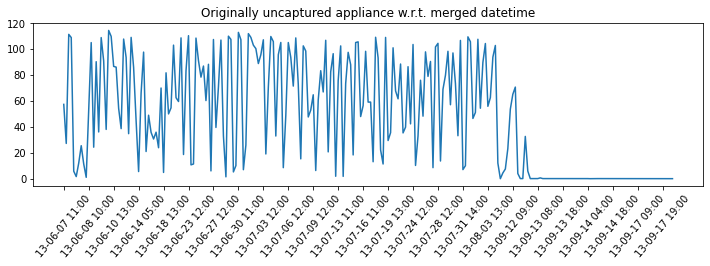

In [9]:
y = df.iloc[:,14]
fig, ax = plt.subplots()
fig.set_size_inches(12,3)
plt.plot(x, y)
plt.xticks(rotation=50)
ax.set_title('Originally uncaptured appliance w.r.t. merged datetime')
ax.set_xticks([x[i] for i in range(0, len(x), 10)]);
#No conspicuous patterns were found for the uncaptured appaince. While the consumption fluctuates from around 0 to 120,
#it drops to nearly 0 starting from mid-September.

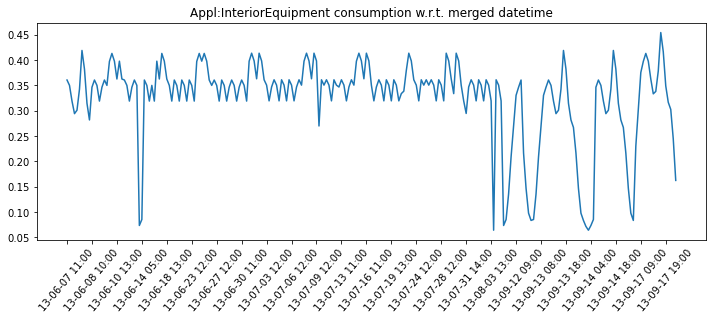

In [10]:
#plot Appl:InteriorEquipment consumption w.r.t. merged datetime.
y = df.iloc[:,11]
fig, ax = plt.subplots()
fig.set_size_inches(12,4)
plt.plot(x, y)
plt.xticks(rotation=50)
ax.set_title('Appl:InteriorEquipment consumption w.r.t. merged datetime')
ax.set_xticks([x[i] for i in range(0, len(x), 10)]);

#The plot shows some observable patterns. For example, from around mid-June to mid-July, the consumption
#has 2 "peaks" followed by three up and down movements with smaller amplitudes. This pattern repeated 
#itself for 5 times. Starting form mid_September, the consumption has higher fluctuations. The consumption
#drops to as low as between 0.05 to 0.1 and then reached the 2 peaks again. This patterns repeated for 3 times.

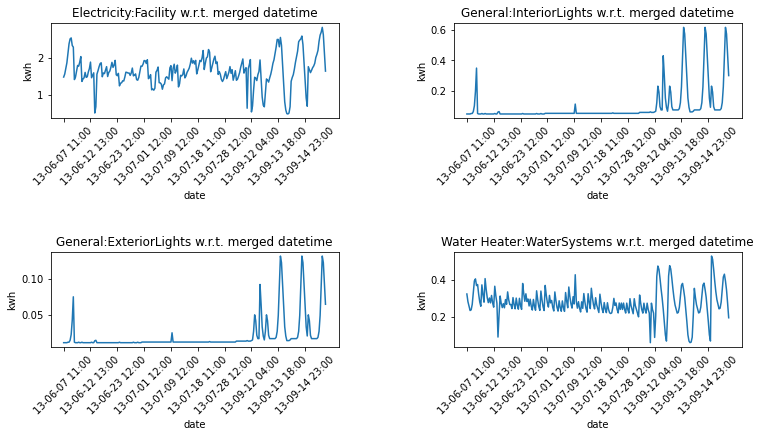

In [11]:
#Generate a subplot of some equipment consumptions to find if there is any similarity.
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,5)
axs[0,0].plot(x,df.iloc[:,1])

axs[0,0].set_xticks([x[i] for i in range(0, len(x), 25)])
axs[0,0].tick_params(axis='x', labelrotation = 45)
axs[0,0].set_title('Electricity:Facility w.r.t. merged datetime')
axs[0,0].set_xlabel('date')
axs[0,0].set_ylabel('kwh')

axs[0,1].plot(x,df.iloc[:,9])
axs[0,1].set_xticks([x[i] for i in range(0, len(x), 25)])
axs[0,1].tick_params(axis='x', labelrotation = 45)
axs[0,1].set_title('General:InteriorLights w.r.t. merged datetime')
axs[0,1].set_xlabel('date')
axs[0,1].set_ylabel('kwh')

axs[1,0].plot(x,df.iloc[:,10])
axs[1,0].set_xticks([x[i] for i in range(0, len(x), 25)])
axs[1,0].tick_params(axis='x', labelrotation = 45)
axs[1,0].set_title('General:ExteriorLights w.r.t. merged datetime')
axs[1,0].set_xlabel('date')
axs[1,0].set_ylabel('kwh')

axs[1,1].plot(x,df.iloc[:,13])
axs[1,1].set_xticks([x[i] for i in range(0, len(x), 25)])
axs[1,1].tick_params(axis='x', labelrotation = 45)
axs[1,1].set_title('Water Heater:WaterSystems w.r.t. merged datetime')
axs[1,1].set_xlabel('date')
axs[1,1].set_ylabel('kwh')

fig.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=1, 
                wspace=0.4, 
                hspace=1.4);
#The below columns of electricity consumptions have a common phenomenom that the consumptions fluctuates a lot more
# starting from mid-September.

In [12]:
df.weekday.value_counts()

4    52
5    46
3    36
1    34
6    28
0    28
2    21
Name: weekday, dtype: int64

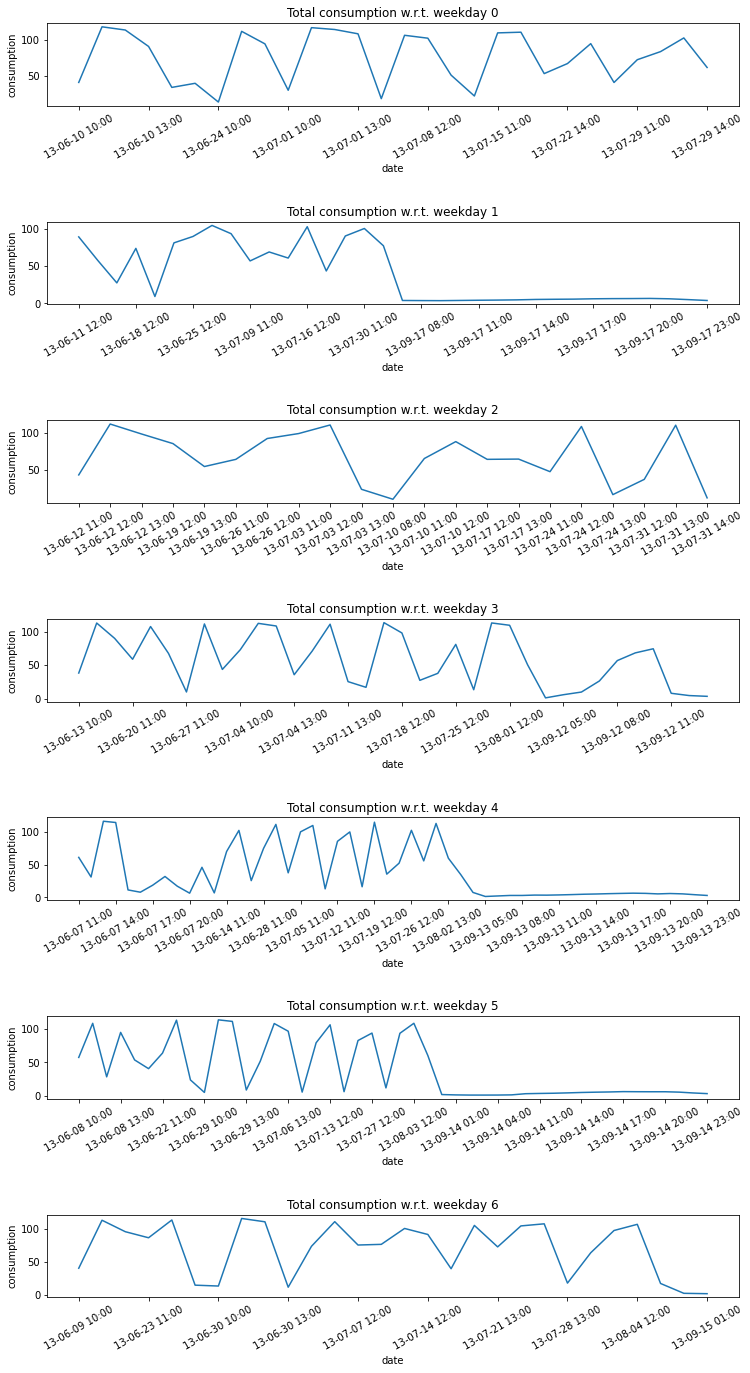

In [23]:
#Try finding if there is any patterns by plotting the total consumption by day of the week. Sunday stands for weekday 0,
#Monday stands for 1, and so on. The overlapped dates are not uniform, nor are the weekdays. Monday, Thursday, and Friday
#have consumption data in mid September while others not. No conspicuous patterns found.
plots = plt.figure(figsize=(12,3))
plot_num_start = 710
for i in range(7):
    plot_num = plot_num_start + i + 1
    ax = plots.add_subplot(plot_num)
    df_filter = df[df.weekday == i]
    x = df_filter.time.dt.strftime('%y-%m-%d %H:%M').to_list()
    plt.plot(x, df_filter.total_consumption_kwh)
    plt.title('Total consumption w.r.t. weekday ' + str(i))
    plt.xlabel('date')
    plt.ylabel('consumption')
    plt.xticks(rotation=30)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=6, 
                    wspace=0.4, 
                    hspace=1.4)
    if len(x) > 25:
         plt.xticks([x[i] for i in range(0, len(x), 3)])

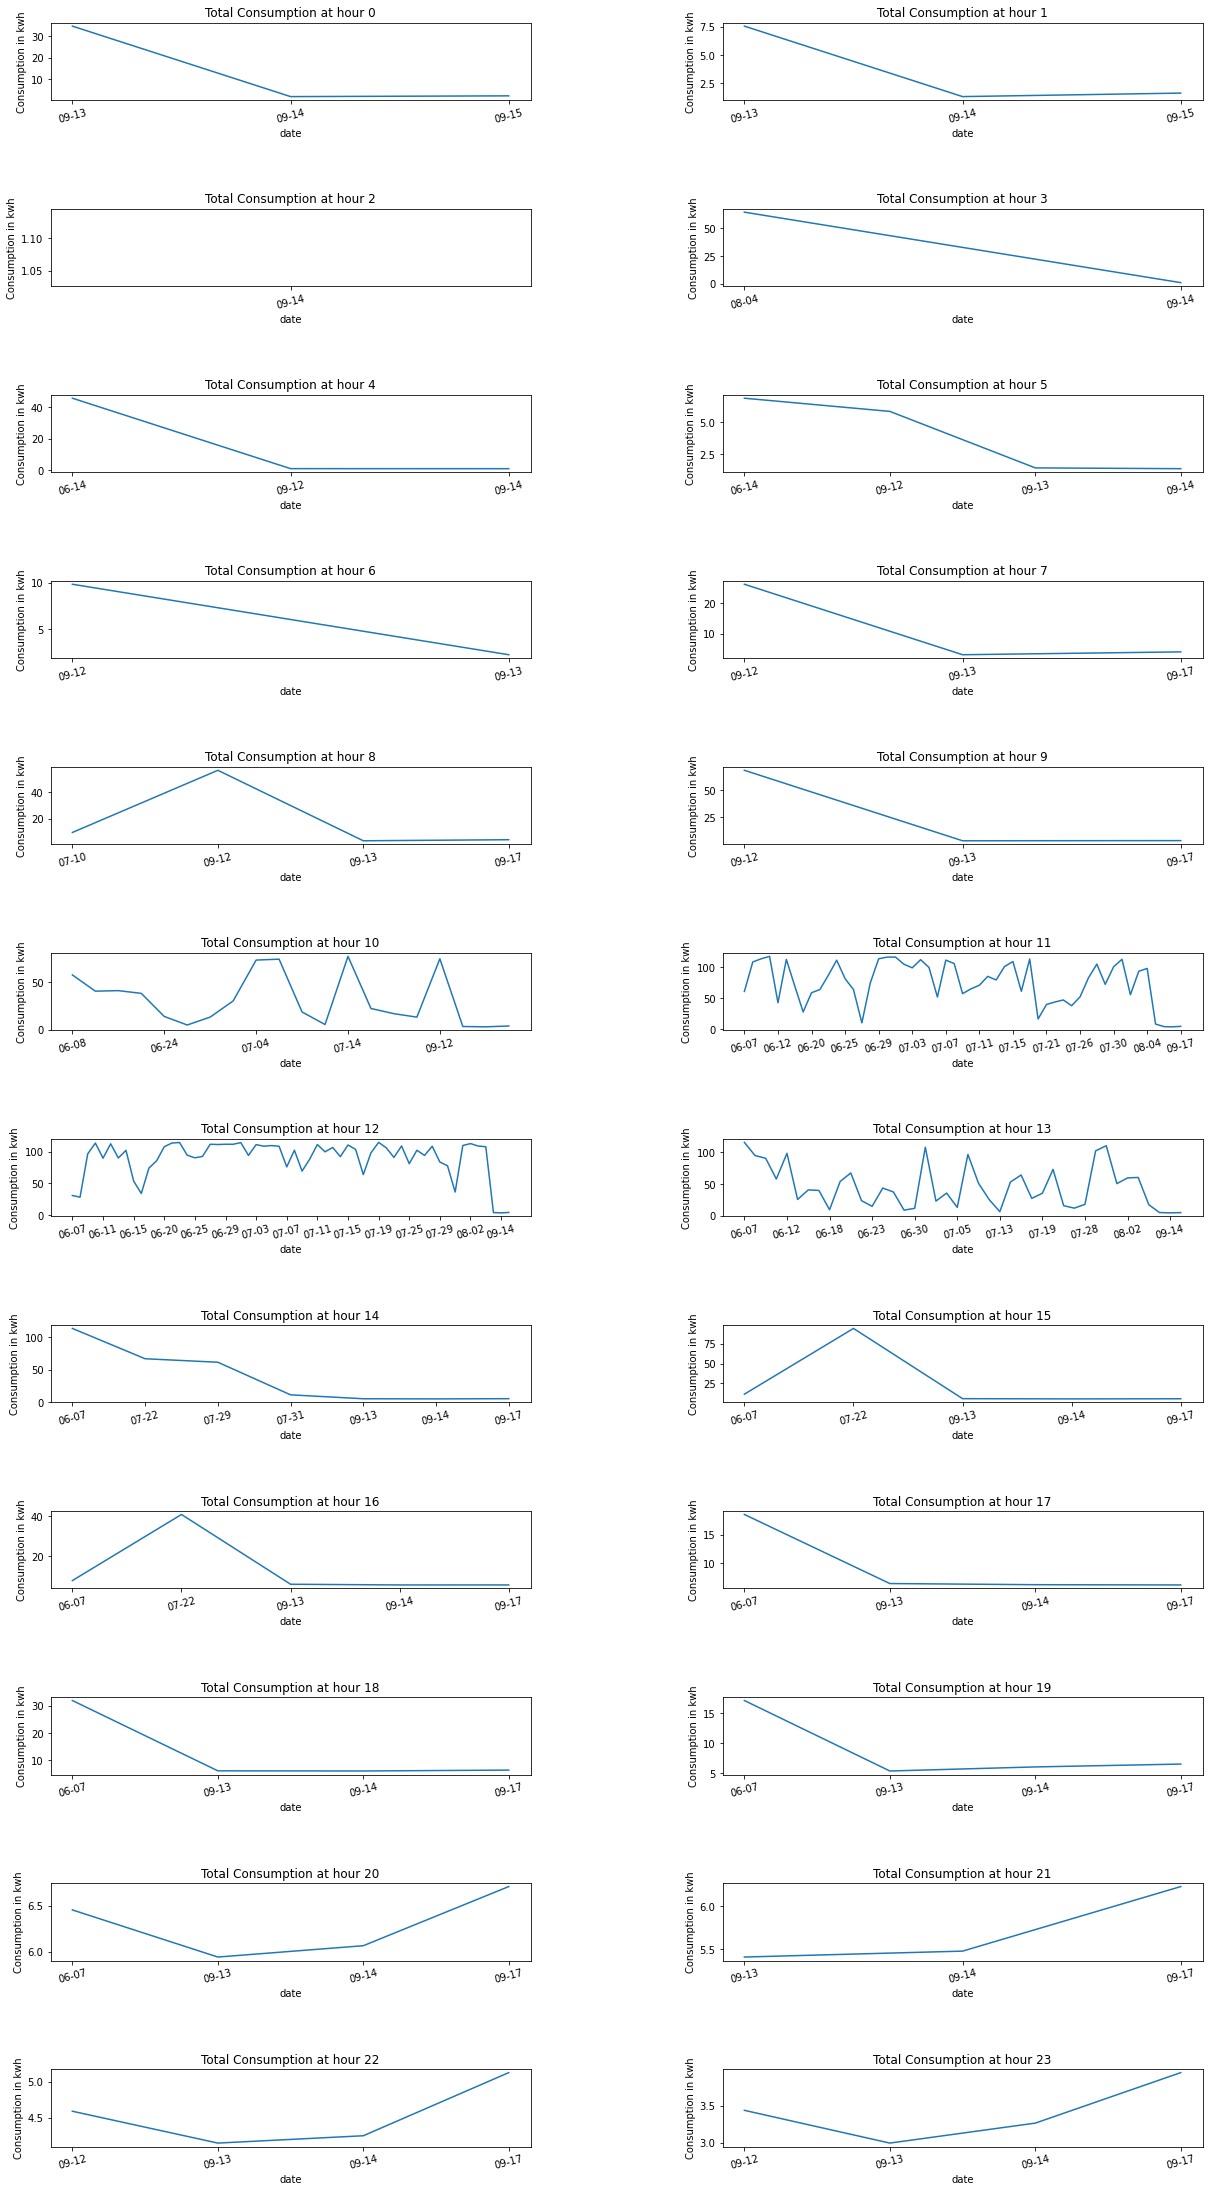

In [15]:
#Try finding patterns by plotting total consumptions based on hour. Some hours have sufficient amount of data while 
#some only have 1 or 2 observations. The consumption data from this merged sample doesn't show repetitive characteristics.
fig, axes = plt.subplots(12, 2)
fig.set_size_inches(20,5)
for i in range(24):
    df_filter = df[df.hour == i]
    x = df_filter.time.dt.to_timestamp().dt.strftime('%m-%d').to_list()
    axes[i//2,i%2].plot(x, df_filter.total_consumption_kwh)
    axes[i//2,i%2].set_title('Total Consumption at hour ' + str(i))
    axes[i//2,i%2].set_xlabel('date')
    axes[i//2,i%2].set_ylabel('Consumption in kwh')
    axes[i//2,i%2].tick_params(axis='x',labelrotation = 15)
    axes[i//2,i%2].tick_params(axis='y')
    if len(x) > 10:
        axes[i//2,i%2].set_xticks([x[i] for i in range(0, len(x), 4)])
    fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=6, 
                    wspace=0.4, 
                    hspace=1.4)